In [13]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from neptune.sessions import Session
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.externals import joblib
import lightgbm as lgb

mpl.rcParams['figure.figsize'] = (16,12)

In [2]:
project = Session().get_project('neptune-ml/credit-default-prediction')
experiments = project.get_experiments(id=['CRED-55','CRED-54', 'CRED-80', 'CRED-81'])
experiments

[Experiment(CRED-54),
 Experiment(CRED-55),
 Experiment(CRED-80),
 Experiment(CRED-81)]

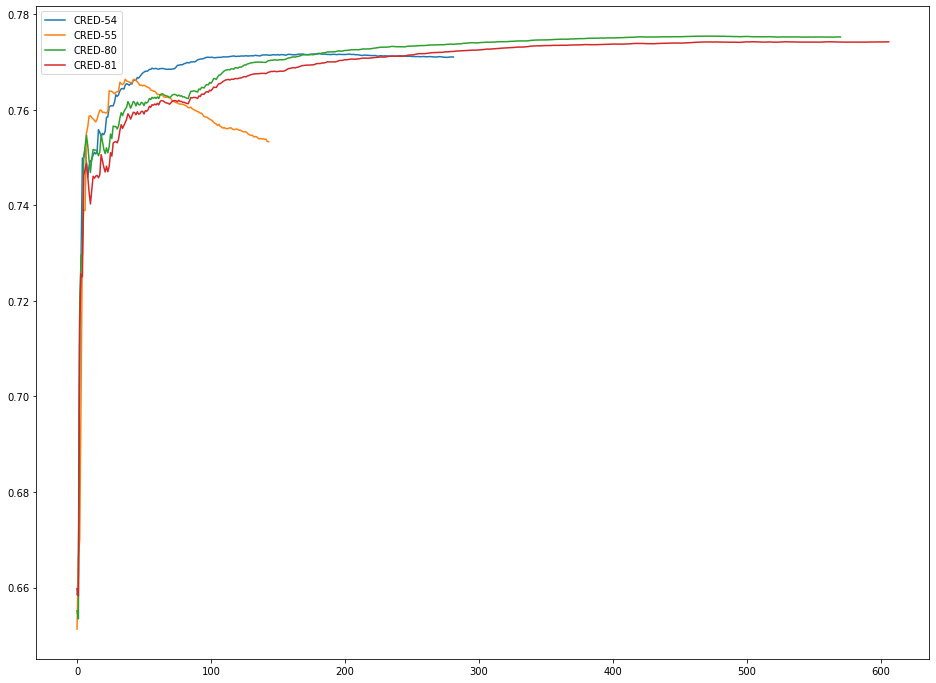

In [14]:
fig, ax = plt.subplots()
for exp in experiments:
    df = exp.get_numeric_channels_values('valid_iter_auc')
    ax.plot(df.x, df.valid_iter_auc, label=exp.id)
plt.legend()
plt.show()

# Best Model 
Let's take a look at the best experiment 
## Model training and parameters

In [4]:
exp = project.get_experiments(id=['CRED-80'])[0]
exp

Experiment(CRED-80)

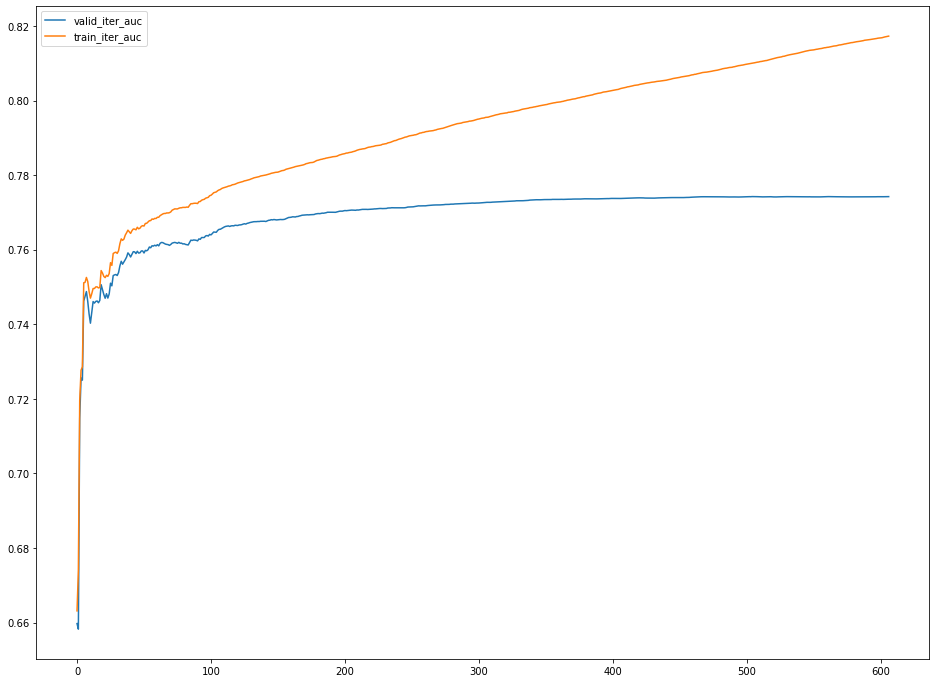

In [21]:
fig, ax = plt.subplots()
df = exp.get_numeric_channels_values('train_iter_auc','valid_iter_auc')
ax.plot(df.x, df.valid_iter_auc, label='valid_iter_auc')
ax.plot(df.x, df.train_iter_auc, label='train_iter_auc')
plt.legend()
plt.show()

In [5]:
exp.get_properties()

{'features_path': 'data/processed/features_joined_v1.csv',
 'features_version': 'e1f5a473fedb57d12a792c02cc52993d',
 'train_split_version': '41bf231b7dc76abb7a2fe15e5cbd9d20',
 'valid_split_version': '4b61d05c05aa16f71015614e3e3b1d1a'}

In [6]:
exp.get_parameters()

{'num_boost_round': 1000.0,
 'early_stopping_rounds': 100.0,
 'metric': 'auc',
 'seed': 1234.0,
 'num_threads': 2.0,
 'learning_rate': 0.013724717780868532,
 'max_depth': 19.0,
 'num_leaves': 100.0,
 'min_data_in_leaf': 102.0,
 'feature_fraction': 0.26591195670286455,
 'subsample': 0.9106895800092479}

In [22]:
exp.download_artifact('model.pkl', '../models/temp')
model = joblib.load('../models/temp/model.pkl')

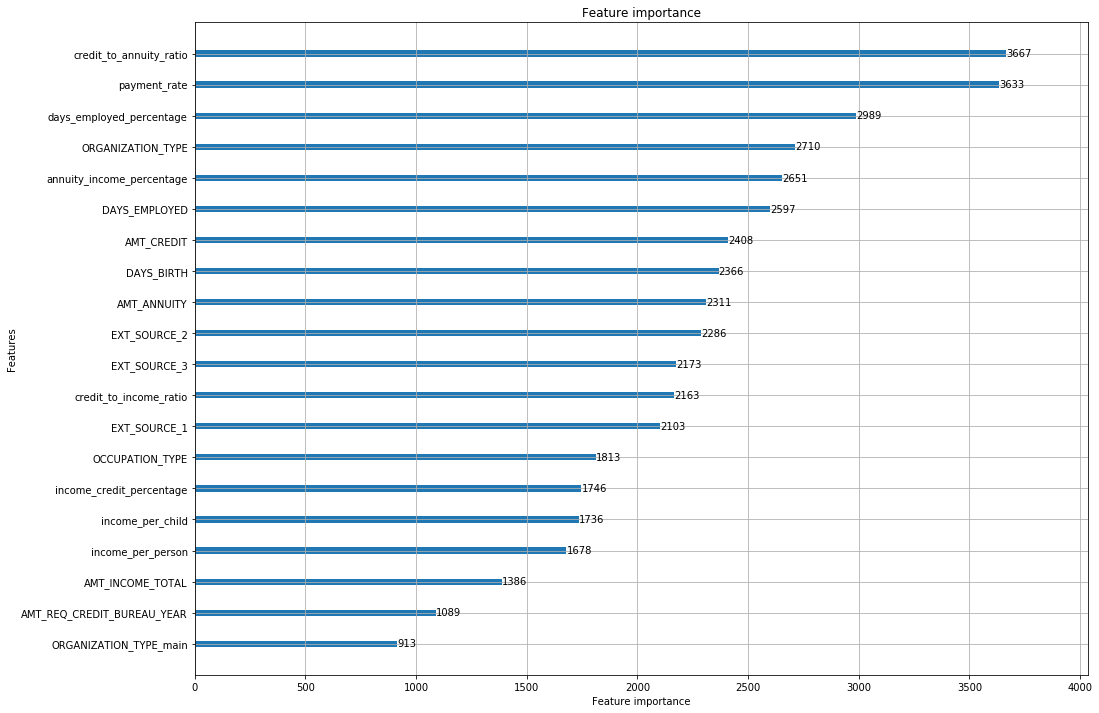

In [23]:
ax = lgb.plot_importance(model, max_num_features=20)

## Model predictions

In [24]:
exp.download_artifact('train_preds.csv', '../models/temp')
exp.download_artifact('valid_preds.csv', '../models/temp')

train_preds = pd.read_csv('../models/temp/train_preds.csv')
valid_preds = pd.read_csv('../models/temp/valid_preds.csv')

In [25]:
valid_preds.head()

,SK_ID_CURR,TARGET,preds_neg,preds_pos
0,455858,0,0.938669,0.061331
1,268345,0,0.924869,0.075131
2,426693,0,0.798780,0.201220
3,221937,0,0.787712,0.212288
4,426636,0,0.918177,0.081823


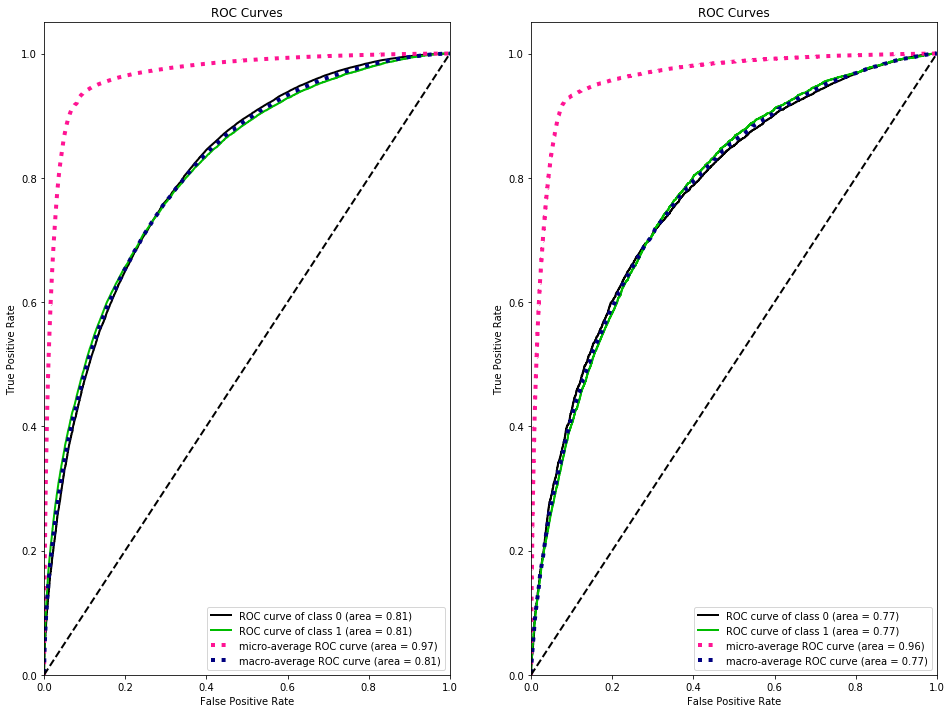

In [29]:
from scikitplot.metrics import plot_roc

fig, axs = plt.subplots(1,2)
plot_roc(train_preds['TARGET'], train_preds[['preds_neg','preds_pos']], ax=axs[0])
plot_roc(valid_preds['TARGET'], valid_preds[['preds_neg','preds_pos']], ax=axs[1])
plt.show()

# Worst results

Let's get worst predictions from the validation set.

In [35]:
valid_preds['abs_error'] = abs(valid_preds['TARGET']-valid_preds['preds_pos'])

worst_valid_ids = valid_preds[['SK_ID_CURR','abs_error']]
worst_valid_ids.head()

,SK_ID_CURR,abs_error
59738,405180,1.011105
7109,415611,1.005837
2699,113817,1.004212
28694,239459,1.002918
41492,385198,1.002564


In [41]:
exp.get_properties()

{'features_path': 'data/processed/features_joined.csv',
 'features_version': '2b1bd1a0ace2dd31078c6ca8653f6c73',
 'train_split_version': '41bf231b7dc76abb7a2fe15e5cbd9d20',
 'valid_split_version': '4b61d05c05aa16f71015614e3e3b1d1a'}

In [42]:
features = pd.read_csv('../data/processed/features_joined.csv')

In [49]:
valid_errors = pd.merge(valid_preds[['SK_ID_CURR','abs_error']], features, on='SK_ID_CURR')

In [50]:
valid_errors.sort_values('abs_error', ascending=False, inplace=True)
valid_errors.head(10)

,SK_ID_CURR,abs_error,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_DAY,EXT_SOURCE_2,CNT_FAM_MEMBERS,AMT_CREDIT,CNT_CHILDREN,EXT_SOURCE_3,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,ORGANIZATION_TYPE_main,ORGANIZATION_TYPE_subtype
0,405180,1.011105,0.0,0.0,0.0,0.730605,2.0,1350000.0,0.0,0.792264,...,4,1,1,0,1,7,6,4,3,5
1,415611,1.005837,0.0,0.0,0.0,0.679484,2.0,270000.0,0.0,0.621226,...,1,1,1,1,1,1,5,5,3,6
2,113817,1.004212,1.0,0.0,0.0,0.675686,2.0,1232793.0,0.0,0.670652,...,1,1,1,0,1,4,6,31,17,13
3,239459,1.002918,0.0,0.0,0.0,0.663163,2.0,792000.0,0.0,0.698668,...,1,1,4,0,0,1,18,43,30,13
4,385198,1.002564,NaN,NaN,NaN,0.752749,3.0,180000.0,1.0,NaN,...,4,1,1,1,1,1,0,5,3,6
5,142286,1.002039,0.0,0.0,0.0,0.638321,2.0,315000.0,0.0,0.676993,...,1,1,1,1,1,1,10,39,26,13
6,321282,1.002009,0.0,0.0,0.0,0.702687,2.0,508495.5,0.0,0.807274,...,4,1,1,0,0,1,18,5,3,6
7,267695,1.001780,0.0,0.0,0.0,0.736117,2.0,876019.5,0.0,0.647977,...,1,1,1,0,1,1,10,5,3,6
8,156201,1.000109,0.0,0.0,0.0,0.757990,1.0,1026000.0,0.0,0.659406,...,4,5,1,0,1,4,11,33,20,13
9,371447,0.999788,0.0,0.0,0.0,0.727517,2.0,1305000.0,0.0,0.684828,...,1,1,1,1,0,1,4,5,3,6


In [52]:
valid_errors.sort_values('abs_error', ascending=True, inplace=True)
valid_errors.head(10)

,SK_ID_CURR,abs_error,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_DAY,EXT_SOURCE_2,CNT_FAM_MEMBERS,AMT_CREDIT,CNT_CHILDREN,EXT_SOURCE_3,...,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_INCOME_TYPE,OCCUPATION_TYPE,ORGANIZATION_TYPE,ORGANIZATION_TYPE_main,ORGANIZATION_TYPE_subtype
61502,266519,0.000003,0.0,0.0,0.0,0.658831,2.0,270000.0,0.0,0.577969,...,4,1,1,0,1,4,3,34,21,13
61501,164135,0.000004,1.0,0.0,0.0,0.702577,2.0,135000.0,1.0,0.511892,...,1,2,1,1,1,7,10,2,2,13
61500,215048,0.000006,0.0,0.0,0.0,0.595228,2.0,810000.0,0.0,0.654529,...,4,1,1,1,1,4,18,41,28,13
61499,350255,0.000006,0.0,0.0,0.0,0.748183,2.0,191880.0,0.0,0.771362,...,1,1,1,1,1,7,10,5,3,6
61498,192127,0.000008,0.0,0.0,0.0,0.692590,1.0,247500.0,0.0,0.701696,...,1,2,1,1,1,7,18,55,33,7
61497,399110,0.000012,0.0,2.0,0.0,0.627801,2.0,225000.0,0.0,0.763640,...,4,1,1,0,1,3,18,57,19,13
61496,228182,0.000012,0.0,0.0,0.0,0.765161,1.0,679500.0,0.0,0.576209,...,1,3,1,0,1,3,18,57,19,13
61495,224284,0.000012,0.0,0.0,0.0,0.678692,2.0,270000.0,0.0,0.754406,...,4,0,1,1,1,1,12,5,3,6
61494,381655,0.000016,1.0,0.0,0.0,0.724637,2.0,553806.0,0.0,0.740799,...,4,1,1,0,0,7,14,5,3,6
61493,105055,0.000017,0.0,1.0,0.0,0.744353,3.0,2250000.0,1.0,0.673830,...,1,1,1,0,1,7,18,26,12,12
